Modified from
--
https://github.com/compbiomed-unito/MUSE-XAE

Main changes
--
 - it accepts any number of variables (i.e. neurons in the input layer) rather that just the 96 trinucleotide SBS
 - it accepts non-count variables, so loss function is not necessarily Poisson, and normalization is done differently (across-samples standardization) to account for negative values, or not done at all
 - data augmentation is done a priori by resampling coefficients from their CI80%
 - a single and unique resampling is used at each epoch
 - no EarlyStopping (instead I recover the epoch with lowest validation loss)
 - no mapping of signatures to COSMIC
 - no non-negative weights constraint in the decoder (kernel_constraint=NonNeg()), since regional signature weights can be negative
 - each sample's exposure to each signature is obtained
 - it's possible to change the batch size, the % of samples used for validation, and the dimensions (neurons) of the 1st encoder layer (the 2nd and 3rd are fractions thereof)
 - parallelization of number of signatures, and all of the previous point, is done externally with Nextflow

2024-03-07 15:08:22.318385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 142)]             0         
                                                                 
 encoder_layer_1 (Dense)     (None, 200)               28600     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 encoder_layer_2 (Dense)     (None, 100)               20100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 encoder_layer_3 (Dense)     (None, 50)                5050

/opt/conda/envs/musexae/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Using data pair #2 for epoch 2
Using data pair #3 for epoch 3
Using data pair #4 for epoch 4
Using data pair #5 for epoch 5
Using data pair #6 for epoch 6
Using data pair #7 for epoch 7
Using data pair #8 for epoch 8
Using data pair #9 for epoch 9
Using data pair #10 for epoch 10
Using data pair #11 for epoch 11
Using data pair #12 for epoch 12
Using data pair #13 for epoch 13
Using data pair #14 for epoch 14
Using data pair #15 for epoch 15
Using data pair #16 for epoch 16
Using data pair #17 for epoch 17
Using data pair #18 for epoch 18
Using data pair #19 for epoch 19
Using data pair #20 for epoch 20
Using data pair #21 for epoch 21
Using data pair #22 for epoch 22
Using data pair #23 for epoch 23
Using data pair #24 for epoch 24
Using data pair #25 for epoch 25
Using data pair #26 for epoch 26
Using data pair #27 for epoch 27
Using data pair #28 for epoch 28
Using data pair #29 for epoch 29
Using data pair #30 for epoch 30
Using data pair #31 for epoch 31
Using data pair #32 for ep

/opt/conda/envs/musexae/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


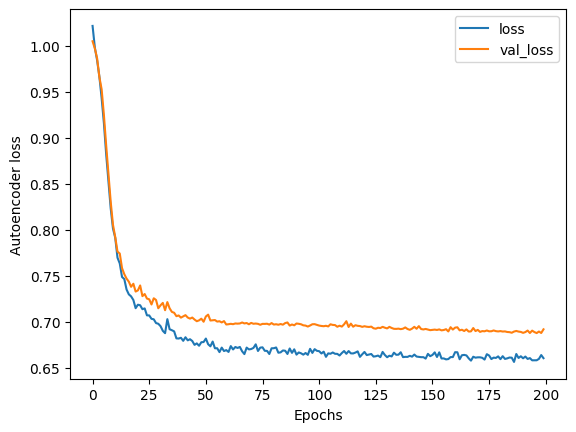

In [1]:
import sys, os, argparse

## load functions from utils.py
from utils import load_dataset, train_model, encoder_prediction


## pass arguments
parser = argparse.ArgumentParser()
parser.add_argument('-r', '--real_data', type=str, required=True, help='Real dataset (i.e. before resamplings), all samples')
parser.add_argument('-t', '--filename_dataset_permuted_training', type=str, required=True, help='PERMUTED TRAINING samples multiple tables (output from 1_parse_input.R; .tsv)')
parser.add_argument('-v', '--filename_dataset_permuted_validation', type=str, required=True, help='PERMUTED VALIDATION samples single table (output from 1_parse_input.R; .tsv)')
parser.add_argument('--n_signatures', type=int, help='Number of signatures (neurons in the latent space) to explore', default = 2, required=False)
parser.add_argument('--epochs', type=int, default=1000, help='Number of epochs; WARNING: there needs to exist in ./documents/ 1 different resampled training table per epoch, with the training filenames reflecting this, i.e. ./documents/*iter[1:epochs]*')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
parser.add_argument('--l1_size', type=int, default=128, help='N neurons of the first encoder layer; the 2nd and 3rd are fractions thereof')
parser.add_argument('--validation_perc', type=int, default=20, help='% of the total samples that is reserved for validation; this is done a priori with 1_parse_input.R')
parser.add_argument('--loss', type=str, default='mean_squared_error', help='Loss function to use in the autoencoder')
parser.add_argument('--activation', type=str, default='softplus', help='Activation function')
parser.add_argument('--normalization', type=bool, default=True, help='Whether or not to perform standardization of the input layer (coefficients)')
parser.add_argument('--seed', type=int, required=False, help='Specify a seed, otherwise it will be selected based on the current time')
parser.add_argument('--outputDir', type=str, default='./res/', help='Directory to save results')

if 'ipykernel' in sys.modules: # if interactive, pass values manually
    real_data = "original_coeff.tsv"
    filename_dataset_permuted_training = "perm_coeff_iter*_training.tsv"
    filename_dataset_permuted_validation = "perm_coeff_validation.tsv"
    n_signatures = 3
    epochs = 200
    batch_size = 25
    l1_size = 200
    validation_perc = 30
    loss = 'mean_squared_error'
    activation = 'softplus'
    normalization = True
    outputDir = "./res/"
else:
    args = parser.parse_args()
    

## load datasets
# they have to be in ./datasets/validation_perc_{validation_perc}/
# n_features indicates the number of input neurons (1 per feature included in regressions)
# there must be as many available training files as epochs are specified
real_data_df,real_data_sample_names,feature_names,n_features,training_validation_dfs_dict,seed = load_dataset(real_data,
                                                                                                              filename_dataset_permuted_training,
                                                                                                              filename_dataset_permuted_validation,
                                                                                                              epochs,
                                                                                                              validation_perc,
                                                                                                              normalization,
                                                                                                              seed=None)
## create output folder
output_folder_name = f'nFeatures_{str(n_features)}__' \
                     f'nSignatures_{str(n_signatures)}__' \
                     f'nEpochs_{str(epochs)}__' \
                     f'batchSize_{str(batch_size)}__' \
                     f'l1Size_{str(l1_size)}__' \
                     f'validationPerc_{str(validation_perc)}__' \
                     f'normalization_{str(normalization)}__' \
                     f'seed_{str(seed)}/'

if 'ipykernel' in sys.modules: # if interactive, create folders
    if not os.path.exists(outputDir):
        os.mkdir(outputDir)
    output_folder_name = outputDir + output_folder_name
    if not os.path.exists(output_folder_name):
        os.mkdir(output_folder_name)
else: ## not interactive (nextflow handles the autoencoder_output folder creation)
    output_folder_name = outputDir + output_folder_name
    os.mkdir(output_folder_name)

    
## run training with simultaneous validation
trained_autoencoder,trained_encoder,loss_plot,signature_weights = train_model(training_validation_dfs_dict = training_validation_dfs_dict,
                                                                              input_dim = n_features,
                                                                              feature_names = feature_names,
                                                                              n_signatures = n_signatures,
                                                                              epochs = epochs,
                                                                              batch_size = batch_size,
                                                                              l1_size = l1_size,
                                                                              loss = loss,
                                                                              activation = activation,
                                                                              seed = seed,
                                                                              output_folder_name = output_folder_name)


## now use the trained 'encoder' model (already trained via the autoencoder, see above) to encode the original (i.e. not resampled) coefficients matrix into the latent representation
encoded_real_df = encoder_prediction(trained_encoder, 
                                     real_data_df, 
                                     real_data_sample_names, 
                                     n_signatures)


## save outputs

# training performance plot
loss_plot.savefig(output_folder_name + 'loss_plot.jpg', dpi=100)    

# best encoder model 
trained_encoder.save(output_folder_name + 'best_encoder_model.tf')

# encoded layer ("signature exposures")
encoded_real_df.to_csv(output_folder_name + 'signature_exposures.tsv', sep='\t', index= False)

# decoder layer weights ("signature weights")
signature_weights.to_csv(output_folder_name + 'signature_weights.tsv', sep='\t', index= False)